In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math

# Analyse et visualisation des résultats


In [ ]:
data = pd.read_csv("train.csv", index_col = "DateTime", parse_dates = True)
data_prev = pd.read_csv("prev.csv" , index_col = "DateTime", parse_dates = True)

<Axes: title={'center': 'EmissionCO2'}, xlabel='DateTime'>

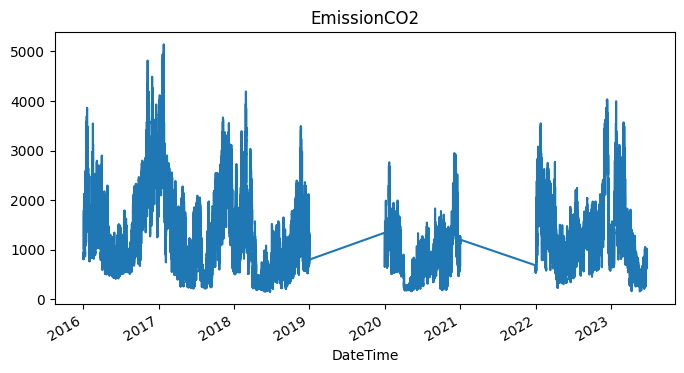

In [ ]:
data['EmissionCO2'].plot(kind='line', figsize=(8, 4), title='EmissionCO2')

<ipython-input-34-a2a1891a16a9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='EmissionCO2', y='Jour', inner='box', palette='Dark2')


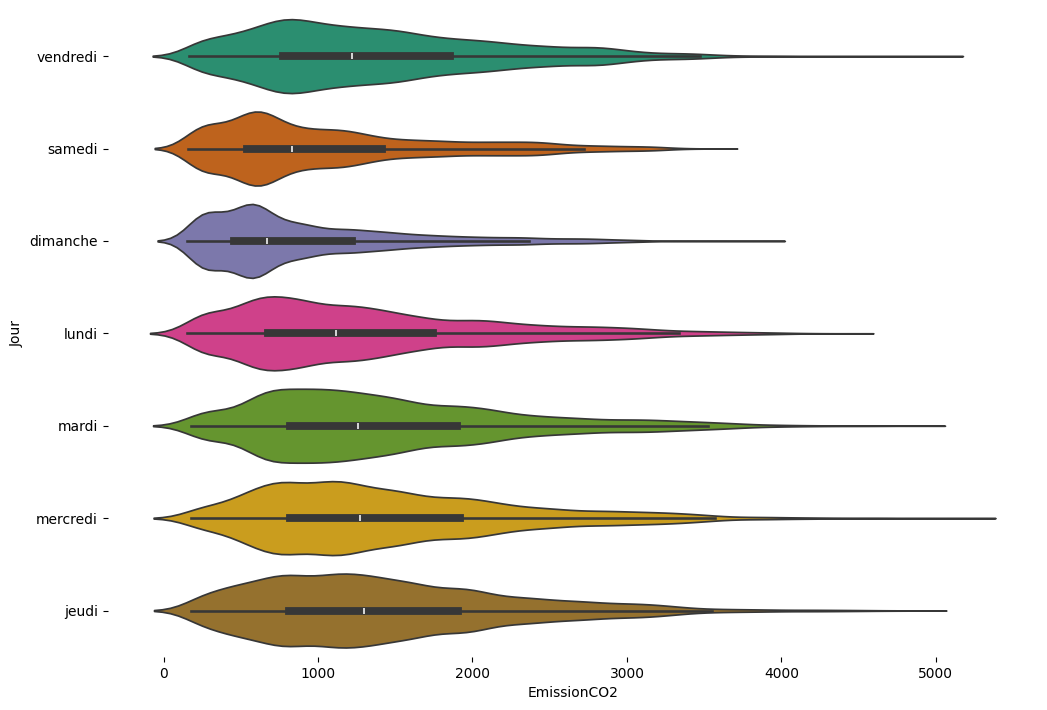

In [ ]:
import seaborn as sns
figsize = (12, 1.2 * len(data['Jour'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='EmissionCO2', y='Jour', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<Axes: >

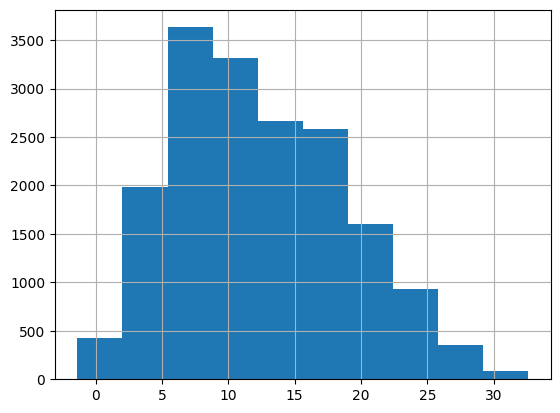

In [ ]:
data[data['Annee']==2016]["Temperature"].hist(bins=10)

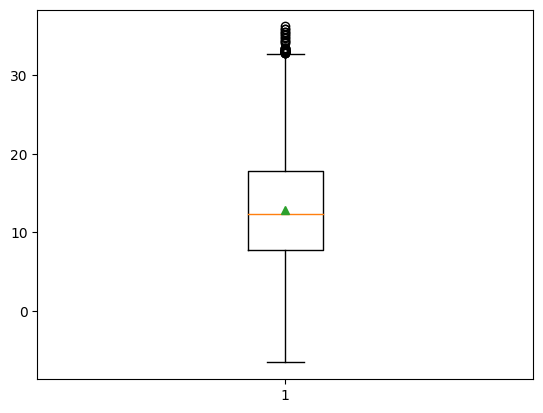

In [ ]:
_ = plt.boxplot([data["Temperature"]],showmeans = True)

In [ ]:
data["Temperature"].corr(data["EmissionCO2"])

-0.48915490164563796

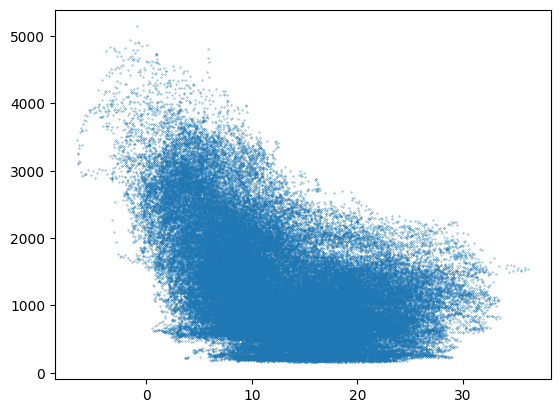

In [ ]:
plt.scatter(data["Temperature"], data["EmissionCO2"], s = 0.07)

# Construction de nouvelles variables
Dans le but de prédire plus précisément les résultats et d'optimiser le traitement des données, de nouvelles variables ont été créées pour regrouper d'autres variables ou créer de nouvelles propriétés. Certaines variables ont été normalisées.


In [ ]:
# Les valeurs (x<0) indiquant l'absence de précipitations sont remplacées par 0
data["Precipitation"] = data["Precipitation"].apply(lambda x: max(x,0))
data_prev["Precipitation"] = data_prev["Precipitation"].apply(lambda x: max(x,0))

# Vacances dans une des zones
data["Vacances"] = data["VacancesZoneA"]|data["VacancesZoneB"]|data["VacancesZoneC"]
data_prev["Vacances"] = data_prev["VacancesZoneA"]|data_prev["VacancesZoneB"]|data_prev["VacancesZoneC"]

# Normalisation du jour de la semaine dans une notation numérique où (0) est lundi, (6) est dimanche
data["Jour_Numero"] = data.index.weekday
data_prev["Jour_Numero"] = data_prev.index.weekday

# Une variable discrète indiquant si un jour est un week-end ou un jour férié
data['week-end'] = (data["Jour_Numero"]>4) & (data["JourFerie"])
data_prev['week-end'] = (data_prev["Jour_Numero"]>4) & (data_prev["JourFerie"])

# Une variable discrète indiquant si les lectures ont été prises pendant la journée de travail.
data['work_day'] = (data["DemiHeure"]>=16) & (data["DemiHeure"]<=44)
data_prev['work_day'] = (data_prev["DemiHeure"]>=16) & (data_prev["DemiHeure"]<=44)

# Une variable discrète indiquant si les lectures ont été prises pendant l'hiver + 2 mois "froides"
data['winter'] = (data["Mois"]=='janvier') | (data["Mois"]=='fevrier') | (data["Mois"]=='mars') | (data["Mois"]=='decembre') | (data["Mois"]=='novembre')
data_prev['winter'] = (data_prev["Mois"]=='janvier') | (data_prev["Mois"]=='fevrier') | (data_prev["Mois"]=='mars') | (data_prev["Mois"]=='decembre') | (data_prev["Mois"]=='novembre')

# Normalisation du temps à une norme généralement acceptée
data["Heure_indx"] = data.index.hour
data_prev["Heure_indx"] = data_prev.index.hour

Les variables quantitatives étant dans des unités différents, il faut les centrer et réduire afin de pouvoir comparer les distances entre elles dans l'algorithme de knn. Cette fonction retourne un nouveau `DataFrame` avec les variables centrées et réduites.

In [ ]:
def normalize(m_data : pd.DataFrame):
  """Retourne un nouveau DataFrame avec les variables centrées et réduites, c'est-à-dire,
  pour chaque variable, la moyenne et l'écart type sont calculés, puis on reste la moyenne
  et divise entre l'écart type.

    Args:
        m_data (pd.DataFrame): DataFrame où chaque colonne répresent une variable à normaliser.

    Returns:
        pd.DataFrame: DataFrame où chaque colonne correspond à une variable (dans le même ordre que le df passé en paramètre) centrée et réduite.
  """
  # Création d'un DataFrame vide.
  df = pd.DataFrame()

  for label in m_data.columns:

    # À chaque colonne reste sa moyenne et divise entre l'écart type.
    df[label] = (m_data[label]-np.mean(m_data[label]))/np.std(m_data[label])

  return df

In [ ]:
data_norm = normalize(data[["Temperature", "Nebulosity", "Humidity", "WindSpeed", "Precipitation"]])
data_norm["MixProdElec"] = data["MixProdElec"]



---




# Stratégie de validation

On souhaite estimer la probabilité d’erreur de notre modèle. Tester sur le même ensemble qui a été utilisé pour l’apprentissage donnerait une estimation biaisée ou pourrait causer surapprentissage. Donc, pour avoir une estimation plus proche de la réalité, on divisera l’ensemble en deux parties, une partie sera utilisée pour l’apprentissage et l’autre pour tester. Ainsi, on testera le modèle dans des « nouvelles » données, des données qui n’ont pas été utilisées pour l’apprentissage. Pour avoir une meilleure estimation, on pourra répéter ce processus plusieurs fois, avec des ensembles différents, et à la fin, on prendra la moyenne de ces estimations.

In [ ]:
def validation_croisee(f,train,n, pct_test, labels):
    """Validation croisee

    Args:
        f (function): Fonction recevant deux arguments, les données d'apprentissage et les données de test et retournant un array avec les classifications.
        train: Données d'apprentissage
        n (int): Nombre de fois que l'algoritme fera la validation croisée.
        pct_test (float): Le pourcentage des données qui seront utilisés pour l'apprentissage (le reste pour test).
        labels: Array avec les classifications vraies.

    Returns:
        float : Le taux d'erreur (le plus proche de 0, le mieux).
    """
    # Création d’une liste que contiendra le taux d’erreur de chaque itération.
    taux_erreur = []

    for i in range(n):

        # On tire au hasard des indexes qui serviront à extraire l’ensemble d’apprentissage.
        # Le nombre d’indexes est donné par la proportion apprentissage/test passée en paramètre.
        train_indx = np.random.randint(0, high = len(train)-1, size=int(pct_test*len(train)))

        # Transformation en set afin d’avoir un temps d’accès plus rapide
        train_set = {x for x in train_indx}

        # Les indexes de test seront tous ceux qui ne sont pas d’apprentissage
        test_indx = np.array([x for x in range(len(train)) if x not in train_set])

        # Extraction des données d'apprentissage et test.
        train_data = train.iloc[train_indx]
        test_data = train.iloc[test_indx]

        # La fonction f, passée en paramètre, retourne un array avec les prédictions, étant donnés un ensemble train et un ensemble test.
        res = f(train_data,test_data)

        # On compare les prédictions de f avec les vraies classes pour obtenir le taux d’erreur.
        taux_erreur.append(np.mean(res!=labels[test_indx]))

    # On retourne la moyenne des taux d’erreur.
    return np.mean(taux_erreur)



# Bayes

Le théorème de Bayes permet de retrouver des probabilités conditionnelles. L'application du théorème et d'une classification Bayésienne est très utile dans une analyse de données comme la notre car son principe réside a faire l'estimation de probabilités en fonction de caractéristiques réelles, et permet donc d'avoir une prédiction mais surtout d'avoir sa probabilité d'erreur, ce qui permet d'affiner ses calculs pour trouver les caractéristiques les plus correllées.

In [ ]:
def classifBayes1(train, prev,v):
  """
    Classification Bayésienne.

    Cette fonction implémente une classification bayésienne en se basant sur les données d'entraînement et en utilisant la règle du maximum de vraisemblance.

    Args:
        train (DataFrame): Données d'entraînement contenant les caractéristiques et les classes.
        prev (DataFrame): Données préalables (peut inclure les mêmes caractéristiques).
        v (str): Nom de la variable à classifier.

    Returns:
        Series: Série contenant les classifications basées sur la variable spécifiée.
    """
  # Création d'une table de contingence des fréquences relatives
  tab_converg = pd.crosstab(train['MixProdElec'], train[v],normalize='columns')

  # Obtention de la classe la plus fréquente pour chaque valeur de la variable v
  bayes = tab_converg.idxmax()

  # Application de la règle du maximum de vraisemblance sur les données précédentes pour obtenir les classifications
  res = prev[v].apply(lambda x : bayes[x])
  return res


classifBayes1(data, data_prev, "Jour")



DateTime
2019-01-01 00:00:00    Carbonne
2019-01-01 00:30:00    Carbonne
2019-01-01 01:00:00    Carbonne
2019-01-01 01:30:00    Carbonne
2019-01-01 02:00:00    Carbonne
                         ...   
2021-12-31 21:30:00    Carbonne
2021-12-31 22:00:00    Carbonne
2021-12-31 22:30:00    Carbonne
2021-12-31 23:00:00    Carbonne
2021-12-31 23:30:00    Carbonne
Name: Jour, Length: 35040, dtype: object

In [ ]:
def classif_naif(py, crosstabs, variables):
    """
    Classification naïve en utilisant le théorème de Bayes.

    Cette fonction réalise une classification naïve en utilisant le théorème de Bayes sur plusieurs variables.

    Args:
        py (Series): Probabilités a priori des classes.
        crosstabs (list): Liste des tables de contingence des variables explicatives par rapport à la variable cible.
        variables (list): Liste des noms des variables explicatives.

    Returns:
        int: Indice de la classe prédite.
    """

    # Conversion des probabilités en array numpy
    probas = np.array([x for x in py])

    # Itération sur les tables de contingence et les variables explicatives
    for crs, var in zip(crosstabs, variables):
        # Multiplication des probabilités par les probabilités conditionnelles
        probas = probas*crs[var]

    # Retourne l'indice de la classe ayant la probabilité maximale
    return probas.argmax()

def bayes_naif(train, prev, *variables):
    """
    Classification naïve bayésienne.

    Cette fonction réalise une classification naïve bayésienne en utilisant les fréquences relatives des variables explicatives.

    Args:
        train (DataFrame): Données d'entraînement contenant les variables explicatives et la variable cible.
        prev (DataFrame): Données à classer.
        variables (str): Noms des variables explicatives.

    Returns:
        array: Tableau contenant les classifications.
    """

    # Initialisation de la liste pour stocker les tables de contingence
    tabs = []

    # Calcul des probabilités pour chaque classe
    py = train["MixProdElec"].value_counts()/len(train['MixProdElec'])

    # Calcul des tables de contingence pour chaque variable explicative
    for var in variables:
        tab = pd.crosstab(train['MixProdElec'], train[var], normalize='index')
        tabs.append(tab)

    # Définition des modalités des classes
    modalites = ["Carbonne", "Decarbonne", "Normal"]

    # Classification des données à prédire
    res = []
    for i in range(len(prev)):
        # Utilisation de la fonction de classification naïve pour chaque donnée à prédire
        res.append(modalites[classif_naif(py,tabs, prev[[*variables]].iloc[i])])

    # Retourne les classifications sous forme d'un array numpy
    return np.array(res)



---



# K Plus Proches Voisins

Le principe de k-NN est très simple. On estime qu'une donnée ayant des variables explicatives très similaires à une autre donnée a une forte chance d'appartenir à la même classe. Ainsi, dans différentes régions de l'espace, on peut trouver différentes densités de classes. L'algorithme des k plus proches voisins exploite ce principe : lorsqu'on nous fournit une nouvelle donnée, nous examinons la base de données d'apprentissage et identifions les k données les plus similaires (celles qui sont les plus proches au sens d'une distance euclidienne multidimensionnelle), puis nous prédisons la classe majoritaire parmi ces k plus proches voisins.

Étant donnée un tableau (numpy ou pandas) de classes, cette fonction retourne la classe majoritaire, c-est-à-dire, celle qui apparaît le plus.

In [ ]:
def class_majoritaire(labels) :
    """
    Étant donnée un tableau de classes, cette fonction retourne la classe majoritaire, c-est-à-dire, celle qui apparaît le plus.

    Args:
        labels: Tableau de classes

    Returns:
        La classe majoritaire (de même type que dans le tableau).
    """

    # Création d’une variable avec les différentes classes apparaissant dans le tableau (valeurs) et une autre variable avec la fréquence de chacune (nb_fois).
    valeurs, nb_fois = np.unique(labels,return_counts=True)

    # Utilise argmax pour obtenir l’indice de la classe qui apparaît le plus et retourne cette classe.
    return valeurs[np.argmax(nb_fois)]

Cette fonction prend une nouvelle donnée, ainsi que le tableau des données d’apprentissage et d’un k, pour le classer suivant l’algorithme knn, c’est-à-dire, trouver les k données dans le tableau qui ressemblent le plus à la nouvelle donnée et la classer dans la classe majoritaire des knn.

In [ ]:
def classifie_kppv(k : int, mdesc : np.ndarray, mclass : np.ndarray, x : np.ndarray):
  """
  Fonction qui classifie un array de variables explicatives x utilisant knn avec k = k
  et comme dataset les variables explicatives de mdesc et leurs respectives labels mclass.
  Les variables de type float seront intérprétées comme quantitatives, le reste comme quantitatives.

  Args:
      k (int): Le nombre de voisins à utiliser pour le knn
      mdesc (np.ndarray): Un array multidimensional où chaque colonne represente une variable explicative et chaque ligne une realisation.
      mclass (np.ndarray): mclass[i] répresente La vraie classe associé à la réalisation mdesc[i]
      x (np.ndarray): L'exemple à classer

  Returns:
       La classe predite (de même type que les variables dans mclass).
  """

  # Initialisation d’un nouveau tableau numpy qui contiendra les distances à chaque donnée.
  dist = np.zeros(np.shape(mclass))
  # Initialisation d'une liste qui contiendra les indexes des variables quantitatives
  quanti_indx = []
  # Initialisation d'une liste qui contiendra les indexes des variables qualitatives
  qualy_indx = []

  for i in range(len(x)):
    # Cette boucle parcoure toutes les colonnes pour regarder si elles contiennent des variables qualitatives ou quantitatives.

    if type(mdesc[0,i]) == np.float64 or type(mdesc[0,i]) == float:

      # Les variables quantitatives sont de type float (float ou numpy.float)
      quanti_indx.append(i)

    else:
      # Les variables qui ne sont pas de type float sont considerées comme qualitatives.
      qualy_indx.append(i)

  # Calcul de la distance euclidienne entre la nouvelle donnée et les données d’apprentissage utilisant les variables quantitatives comme cordonnées.
  if quanti_indx != [] : dist = np.sum((mdesc[:,quanti_indx]-x[quanti_indx])**2, axis=1)

  # Pour les variables qualitatives, la distance entre une certaine donnée et la nouvelle donnée sera le nombre de variables qui ont une valeur différente.
  if qualy_indx != [] :
    dist = dist + np.sum((1- (x[qualy_indx] == mdesc[:,qualy_indx]) ), axis = 1)

  # On trie le tableau et prend les premiers k valeurs
  kppv_arg = np.argsort(dist)[0:k]
  # On extrait les classes des k plus proches voisins.
  kppv_labels = mclass[kppv_arg]
  # On retourne la classe majoritaire parmi les k plus proches voisins.
  return class_majoritaire(kppv_labels)


Une fois qu’on a une fonction qui prédit la classe d’une nouvelle donnée utilisant l’algorithme KNN, on a besoin d’une fonction qui fait la prédiction d’un tableau entier. Cette fonction applique à chaque ligne la fonction `classifie_kppv`

In [ ]:
def knn(k : int, mdesc : np.ndarray, mclass : np.ndarray,mprev : np.ndarray):
  """Retourne une prédiction du tableau mprev avec knn, appliquant la fonction
  classifie_kppv à chaque ligne du tableau mprev.

    Args:
        k (int): Le k à utiliser pour knn
        mdesc (np.ndarray): Array des variables descriptives des données d'apprentissage.
        mclass (np.ndarray): Array unidimensionnel des classes des données d'apprentissage.
        mprev (np.ndarray): Array des variables descriptives des données à classifier.

    Returns:
        list: Liste des classes prédites.
  """
  # Création de la liste des résultats.
  res = []
  for ligne in mprev:

    # Applique à chaque ligne la fonction classifie_kppv et ajoute le résultat à la liste des résultats.
    res.append(classifie_kppv(k, mdesc, mclass, ligne))

  return res

Le nombre de voisins utilisés pour l’algorithme affecte le résultat, donc, il est important de choisir un k optimal. Une manière de procéder est d’utiliser un certain k et tester le modèle utilisant validation croisée, puis répéter avec d’autres valeurs. Cette fonction teste tous les k dans un l’intervalle passé en paramètre et retourne celui qui a le taux d’erreur plus faible.

In [ ]:
def meilleur_k(train : pd.DataFrame , train_keys,labels, fois : int, pct_croisee : float, k_min : int, k_max: int, label_key = "MixProdElec"):

    """Fonction qui utilise validation croisée pour tester la fonction de knn, avec valeurs de k de k_min jusqu'à k_max (inclus).

    Args:
        knn_func (fonction): Fonction qui prend comme paramètre k et qui renvoie une fonction knn compatible avec validation_croisée.
        train(DataFrame): Données d'apprentissage
        train_keys(List) : Liste avec les noms des colonnes du DataFrame qui seront utilisées comme variables explicatives.
        labels: Labels correspondant aux données d'apprentissage
        fois (int): Le nombre de fois qui sera execute la validation croisée à chaque fois que k varie.
        pct_croisee (float): Le pourcentage des données qui seront utilisés pour l'apprentissage dans la validation croisée (le reste pour test).
        k_min (int): Le k minimum à utiliser
        k_max (_type_): Le k maximum à utiliser
        label_key (str, optional): _description_. Defaults to "MixProdElec".

    Returns:
        Tuple[int, float]: Renvoie le meilleur k trouvé et le taux d'erreur correspondant.
    """
    # Cette fonction prend crée une fonction de knn avec le k spécifié, compatible avec la validation croisée.
    knnf = lambda k : lambda tr, tes : knn(k, tr[train_keys].to_numpy(), tr[label_key].to_numpy(), tes[train_keys].to_numpy())

    # Création d’une liste vide que contiendra les taux d’erreur des différents k.
    taux =[]

    for k in range(k_min, k_max+1):

       # Récupère le taux d’erreur de la prédiction utilisant knn pour chaque k, obtenu avec validation croisée.
       t = validation_croisee(knnf(k), train,fois, pct_croisee,labels)
       print(f"k : {k}, taux : {t}")
       taux.append(t)
    # Récupère l’index du k qui a obtenu le taux d’erreur le plus faible.
    meilleur = np.argmin(taux)

    # Retourne le meilleur k avec son taux d’erreur.
    return k_min+meilleur, taux[meilleur]


## Exemple d’utilisation

Pour l'exemple, on prend 5000 lignes du tableau au hasard et deux variables explicatives.

In [ ]:
indx = np.random.randint(0,len(data_norm),size=5000)
train_set = data_norm.iloc[indx][["Temperature", "WindSpeed", "MixProdElec"]]
labels = data.iloc[indx]["MixProdElec"]

On teste l'algorithme avec validation croisée, avec k = 200.

In [ ]:
f = lambda train, test : knn(200,train[["Temperature","WindSpeed"]].to_numpy(), train['MixProdElec'], test[["Temperature","WindSpeed"]].to_numpy())

taux_erreur = validation_croisee(f, train_set, 3, 0.8, labels)

print(f"Taux d'erreur avec 3 tours de validation croisée et k = 200 : {taux_erreur}")

Taux d'erreur avec 3 tours de validation croisée et k = 200 : 0.4907366439661279


On obtient 0.48907067341433424, ce qui n'est pas mal, étant donné que c'était un exemple, avec très peu de données et uniquement deux variables explicatives.

Parmi tous nos modèles, KNN est celui qui a eu le meilleur score sur Kaggle. En effet, utilisant comme variables explicatives `["Temperature", "Nebulosity", "Humidity", "WindSpeed", "Precipitation", "Mois", "Jour", "DemiHeure", "PositionDansAnnee", "JourFerie", "Vacances" , "week-end",	"work_day"]` et k = 183, nous avons réussi à avoir un score de 0.56944

# Arbres de décision
Les arbres de décision sont un algorithme de prédiction basé sur la création de branches de développement improvisées pour chacune des situations (variables). L' algorithme vous permet de déterminer la classe la plus probable pour chaque ensemble individuel de variables, comme si vous répondiez aux questions « Oui/Non » ou « Plus/Moins ».

# Arbres de décision pour variables discrètes.
Cet algorithme est applicable uniquement aux variables de l'ensemble de données qui prennent les valeurs VRAI ou FAUX.

L’ indice de Gini (ou coefficient d’ impureté de Gini) mesure combien
de fois un exemple choisi au hasard dans un ensemble serait mal classifié si il
était classifié selon la distribution dans l’ ensemble.

In [ ]:
def gini(variable,train):
    """Calcule l'indice de Gini pour la variable testée.

    Args:
        variable (str) : Nom de variable testée.
        train: Données d'apprentissage

    Returns:
        returne la valeur d'indice de Gini.
    """
    gini = 1

    # Compte le nombre de répétitions de chacune des classes de prédiction pour les lignes dans lesquelles la variable testée est vraie.
    val, nb_fois = np.unique(train[train[variable]==True]["MixProdElec"],return_counts=True)

    # Calcul de l'indice de Gini
    for i in range(len(val)):
        gini = gini - (nb_fois[i]/sum(nb_fois))**2
    return gini

Cette fonction récursive crée un arbre de décision pour un ensemble donné de variables, en sélectionnant les variables par ordre croissant d'indice de Gini.

In [ ]:
def creer_arbres(variables, train):
    """Fonction qui crée un arbre de décision.

    Args:
        variables (List[str]) : Noms des variables sélectionnées pour construire l'arbre.
        train: Données d'apprentissage.

    Returns:
        Renvoie un arbre de décision formé sur l'ensemble de données sélectionné.
    """
    # Toutes les variables sont utilisées
    if (len(variables)==0):
        return class_majoritaire(train["MixProdElec"])

    # Sauvegarde du dictionnaire créé des variables étudiées et de leurs indices de Gini.
    dict_ordre = dict()
    for variable in variables:
        dict_ordre[variable] = gini(variable,train)

    # Sélection de la variable avec l'indice de Gini le plus bas.
    minelem = 1
    category = "" # la variable avec l'indice de Gini le plus bas
    for (key, value) in dict_ordre.items():
        if value < minelem:
            minelem = value
            category = key

    # L’indice de Gini est si faible qu’un développement ultérieur de la branche n’a aucun sens.
    if (minelem<0.1):
        return class_majoritaire(train[train[category]==True]["MixProdElec"])
    # Supprimer une variable sélectionnée de la liste des variables
    variables.remove(category)
    list_gauche = [i for i in variables]
    list_droite = [i for i in variables]
    # Création d'un tuple de tuples qui simulent des branches.
    return (category, creer_arbres(list_gauche,train[train[category]==True]), creer_arbres(list_droite,train[train[category]==False]))

Cette fonction vous permet de déterminer la classe d'un seul ensemble de valeurs, en prenant une décision basée sur une classe précédemment créée.

In [ ]:
def class_arbre(arbre, ligne):
    """Renvoie une classe pour une ligne de données.

    Args:
        arbre (tuple[tuple[...]]) : Arbre de décision, résultat de la fonction précédente.
        ligne: une ligne d'ensemble des données d'apprentissage.

    Returns:
        Classe de ligne sélectionnée.
    """
    category, gauche, droite = arbre

    # Vérifier la vérité de la variable
    if ligne[category] == True:

        # Nous continuons à avancer le long de la branche d'arbre
        if type(gauche)==tuple:
            return class_arbre(gauche, ligne)

        # Nous avons atteint le point final : la valeur de classe
        else:
            return gauche
    else:
        if type(droite)==tuple:
            return class_arbre(droite, ligne)
        else:
            return droite

#Arbres de décision pour un ensemble combiné de variables : discrets et continus

Cette fonction calcule l'indice de Gini pour les variables continues.

In [ ]:
def gini_cont(variable,train,value):
    """Calcule l'indice de Gini pour la variable testée.

    Args:
        variable (str) : Nom de variable testée.
        train: Données d'apprentissage
        value (float) : Valeur de variable

    Returns:
        returne la valeur d'indice de Gini.
    """
    gini = 1
    val, nb_fois = np.unique(train[(train[variable]>=value)]["MixProdElec"],return_counts=True)
    for i in range(len(val)):
        gini = gini - (nb_fois[i]/sum(nb_fois))**2
    return gini

Cette fonction permet de calculer l'indice de Gini pour 3 valeurs d'une variable continue : moyenne - écart type; moyenne; moyenne + écart type. Ensuite, la fonction sélectionne la meilleure valeur.

In [ ]:
def split_gini(variable,train):
    """Calcule l'indice de Gini pour 3 valeurs d'une variable continue.

    Args:
        variable (str) : Nom de variable testée.
        train: Données d'apprentissage

    Returns:
        Renvoie la meilleure valeur d'une variable et l'indice de Gini pour cette valeur.
    """

    # Creation de liste des valeurs de variable.
    tab = train[variable]
    mean = np.mean(tab)
    std = np.std(tab)

    min = mean-std
    max = mean+std

    # On calcure l'indice de Gini pour chaque valeur à tester.
    coupure1 = gini_cont(variable,train,min)
    coupure2 = gini_cont(variable,train,mean)
    coupure3 = gini_cont(variable,train,max)

    # On choisit la meilleure valeur
    coup = [coupure1 ,coupure2, coupure3]
    coups = [min,mean,max]
    minarg = np.argmin(coup)

    # On renvoie un tuple contenant (valeur de Gini, valeur de variable)
    return (coup[minarg],coups[minarg])

Cette fonction est une modification de la fonction précédente. Cette variante est capable de construire des arbres de décision pour un ensemble mixte de variables : discrètes et continues.

In [ ]:
def creer_arbres(variables, train):
    """Fonction qui crée un arbre de décision.

    Args:
        variables (List[str]) : Noms des variables sélectionnées pour construire l'arbre.
        train: Données d'apprentissage.

    Returns:
        Renvoie un arbre de décision formé sur l'ensemble de données sélectionné.
    """
    # Si l'ensemble de données devient vide, nous renvoyons la classe la plus fréquente comme réponse.
    if len(train) == 0:
        return 'Carbonne'

    # Toutes les variables sont utilisées
    if (len(variables)==0):
        return class_majoritaire(train["MixProdElec"])

    # Sauvegarde du dictionnaire créé des variables étudiées et de leurs indices de Gini.
    dict_ordre = dict()
    for variable in variables:
        if type(train[variable].iloc[0])==bool:
            dict_ordre[variable] = gini(variable,train)
        else:
            dict_ordre[variable] = split_gini(variable,train)

    # Sélection de la variable avec l'indice de Gini le plus bas.
    minelem = 1
    category = "" # La variable avec l'indice de Gini le plus bas.
    mei_seuil = -1
    for (key, value) in dict_ordre.items():

        # Avant de choisir la variable on verifie son type
        if type(value)==tuple:
            val_gini,seuil = value
            if val_gini < minelem:
                minelem = val_gini
                category = key
                mei_seuil = seuil
        else:
            if value < minelem:
                minelem = value
                category = key

    # Cas de variable continue
    if type(train[category].iloc[0])!=np.bool_ and type(train[category].iloc[0])!=bool:
        if (minelem<0.1):
            if len(train[train[category]>=mei_seuil]) == 0:
                return class_majoritaire(train[train[category]>=mei_seuil]["MixProdElec"])
            return "Carbonne"
        variables.remove(category)
        list_gauche1 = [i for i in variables]
        list_droite1 = [i for i in variables]
        return ((category,mei_seuil), creer_arbres(list_gauche1,train[train[category]>=mei_seuil]), creer_arbres(list_droite1,train[train[category]<mei_seuil]))

    # Cas de variable discrète
    else:
        if (minelem<0.1):
            if len(train[train[category]>=mei_seuil]) == 0:
                return class_majoritaire(train[train[category]==True]["MixProdElec"])
            return "Carbonne"
        variables.remove(category)
        list_gauche = [i for i in variables]
        list_droite = [i for i in variables]
        return (category, creer_arbres(list_gauche,train[train[category]==True]), creer_arbres(list_droite,train[train[category]==False]))

À son tour, le classificateur a également subi les modifications nécessaires au décompression correcte des variables continues dans les branches de l'arbre.

In [ ]:
def class_arbre(arbre, ligne):
    """Renvoie une classe pour une ligne de données.

    Args:
        arbre (tuple[tuple[...]]) : Arbre de décision, résultat de la fonction précédente.
        ligne: une ligne d'ensemble des données d'apprentissage.

    Returns:
        Classe de ligne sélectionnée.
    """
    category, gauche, droite = arbre

    # On verifie le type noeud avant la décompression
    if type(category) == tuple:
        cat, val = category
        if ligne[cat]>=val:
            if type(gauche)==tuple:
                return class_arbre(gauche, ligne)
            else:
                return gauche
        else:
            if type(droite)==tuple:
                return class_arbre(droite, ligne)
            else:
                return droite
    else:
        if ligne[category] == True:
            if type(gauche)==tuple:
                return class_arbre(gauche, ligne)
            else:
                return gauche
        else:
            if type(droite)==tuple:
                return class_arbre(droite, ligne)
            else:
                return droite
#arbre = creer_arbres(['Jour_Numero','work_day','week-end',"winter","Vacances","JourFerie","Nebulosity","Humidity","WindSpeed","Precipitation",'Temperature'],data)


Au final, nous arrivons à une fonction qui traite l'ensemble des données à l'aide d'arbres de décision.

In [ ]:
def classif_arbres(variables,train,prev):
    """Fonction qui classifie les données en utilisant des arbres décision.

    Args:
        variables (List[str]) : Noms des variables sélectionnées pour classifier.
        train : Données d'apprentissage.
        prev : Données de prédiction

    Returns:
        list: Liste des classes prédites.
    """

    # Création d'un arbre
    arbre = creer_arbres(variables,train)

    # Définition ligne par ligne de la classe
    result = []
    for ligne in prev.iloc:
        result.append(class_arbre(arbre,ligne))
    return result

# Exemple d’utilisation

In [ ]:
taux_erreur = validation_croisee((lambda train,test: classif_arbres(['Jour_Numero','work_day','week-end',"winter","Vacances","JourFerie","Nebulosity","Humidity","WindSpeed","Precipitation",'Temperature'],train,test)) , data, 3,0.8, data['MixProdElec'])

print(f"Taux d'erreur avec 3 tours de validation croisée et une telle liste des variables : {taux_erreur}")

Taux d'erreur avec 3 tours de validation croisée et une telle liste des variables : 0.5019778166979115


# Création des fichiers csv pour Kaggle

D’après le fichier donné par Kaggle, les soumissions doivent être un fichier csv, dont la première colonne correspond au timestamp et la deuxième à la prédiction (carboné, décarboné ou normal).

In [ ]:
import csv
def output_file(timestamp, prediction, name : str):
    """
    Produit un fichier csv avec le format attendu par Kaggle, correspondant à la prédiction passée en paramètre.

    Args:
        timestamp : Array contenant les timestamps de chaque donnée prédite.
        prediction : Array contenant les prédictions.
        name (str): Nom du fichier à créer (avec termination .csv).
    """

    # Création d'un nouveau fichier.
    with open(name, "w", newline="") as file:

        # Initialisation du csv writer
        writer = csv.writer(file)

        # Écriture de la première ligne, correspondant aux noms des colonnes.
        writer.writerow(["DateTime","MixProdElec"])

        for i in range(len(timestamp)):

           # Écriture de chacune des lignes, la première colonne correspondant au timestamp e la deuxième à la prédiction.
           writer.writerow([timestamp[i], prediction[i]])

#  Nos codes en plus
En plus des principaux algorithmes, nous souhaitons présenter ceux qui n'ont pas été inclus dans le projet final en raison de leur incapacité à s'adapter au format de Jupiter Notebooks ou du manque de temps pour leur mise en œuvre.

## Meilleure combinaison des variables explicatives

Un facteur très important dans la prédiction avec knn est le choix des variables explicatives. En effet, il y a des variables qui ont un lien plus fort avec la classe. Donc, il se peut que, lorsqu’on rajoute une nouvelle variable explicative, elle ne fait que rajouter du bruit et la prédiction est pire. D’où le besoin de trouver la combinaison de variables explicatives avec le taux d’erreur le plus faible. Après l’optimisation dans la façon dont knn est exécuté, il ne prend que quelques secondes, donc, tester toutes les combinaisons des variables dans une partie du tableau devient possible en un temps raisonnable.

Pour représenter une combinaison des variables, nous utiliserons des nombres binaires, où chaque chiffre représente une variable explicative, ainsi, il sera 1 si cette variable est dans la combinaison où 0 si elle ne l’est pas. Par exemple, 1001 représente une combinaison avec uniquement la première et dernière variable. De cette façon, une fois qu’on aura parcouru tous les nombres binaires entre 1 et 2^n (où n est le nombre total de variables explicatives), on aura testé toutes les combinaisons possibles.

Le premier pas est donc de créer une fonction qui transforme un nombre entier en un string qui représente ce nombre écrit en binaire, avec n chiffres (donc, il peut y avoir des zéros à gauche).

In [ ]:
def int_to_bin_len(n, length):
  """Retourne un str correspondant au nombre en base 2, avec la longueur specifiée.
  (La fonction ne coupe pas, elle peut juste ajouter des 0 à gauche)

  Args:
      n (int): Le nombre à transformer à base 2
      length (_type_): La longueur du str desirée
  """
  # La fonction bin (built-in) retourne un string commençant par 0b, suivi de la représentation du nombre en binaire.
  #Donc, on ne prend pas les deux premiers caractères.
  binary = bin(n)[2:]

  # Puisque chaque chiffre représente une variable, il faut avoir toujours le même nombre de chiffres.
  # Donc, il faut ajouter les éventuels zéros à gauche pour avoir la bonne taille.
  zeros = "0"*(length-len(binary))

  return zeros+binary

Une fois qu’on a un nombre binaire avec la bonne taille, il faut transformer cette représentation en sa liste d’indexes correspondante. Par exemple, `0011` deviendrait `[2,3]`. En effet, ce nombre représente la combinaison contenant uniquement les variables deux et trois.

In [ ]:
def bin_to_idx_list(n):
  """Transforme un str representant un nombre binaire en une liste
  contenant les indexes des nombres 1. (Ex: "101" -> [0,2])

  Args:
      n (str): string avec un nombre en base 2.

  Returns:
      List[int]: Les indexes des chiffres 1.
  """
  # Création d'une liste vide.
  res = []

  for i in range(len(n)):

    # Ajoute l’index actuel uniquement si le chiffre correspondant est 1.
    if n[i] == "1":
       res.append(i)

  return res

Finalement, puisque on stockera les résultats de la validation croisée dans un dictionnaire où les clés seront les variables utilisées et les valeurs seront les taux d’erreur respectives, on a besoin d’une fonction qui trouve la valeur minimale dans un dictionnaire.

In [ ]:
def min_dic(dic):
  """Trouve la valeure minimale dans les valeures du dictionnaire

  Args:
      dic (dict): Un dictionnaire dans lequel la comparaison (<) des valeures est définie.

  Returns:
      returne la clé de la min valeur du dictionnaire.
  """

  min_key = None
  min_val = None

  for k,v in dic.items():

    if min_key == None:

      # Initialise min_key et min_val dans le premier tour de boucle.
      min_key = k
      min_val = v

    elif v<min_val:

      # Si on trouve une valeur strictement inférieure à la valeur minimale actuelle, elle devient la nouvelle valeur minimale.
      min_key = k
      min_val = v

  return min_key

In [ ]:
def combinaisons(train, labels, fois, pct_croisee, k_min, k_max):
  """
  Teste toutes les combinaisons des variables explicatives du DataFrame avec validation croisée,
  testant chacune pour tous les k dans l’intervalle passé en paramètre. Retourne la clé de la
  meilleure combinaison trouvée, avec le taux d’erreur correspondant.

    Args:
        train (pd.DataFrame): DataFrame contenant uniquement les variables explicatives.
        labels : Array ou liste contenant les classes des données d'apprentissage.
        fois (int): Le nombre de fois que chaque combinaison sera testée avec validation croisée.
        pct_croisee (float): Le pourcentage des données qui seront utilisés pour l'apprentissage (le reste pour test).
        k_min (int): Le k minimal à tester pour chaque combinaison.
        k_max (int): Le k maximal à tester pour chaque combinaison.

    Returns:
        tuple: la clé de la meilleure combinaison trouvée et avec le taux d’erreur correspondant.
  """

  # Récupère L’array avec les noms des variables explicatives.
  cols = train.columns

  # Initialise un dictionnaire vide pour stocker les combinaisons avec son respective taux d’erreur.
  res = {}

  for i in range(2**(len(cols)-1)):

    # Transforme le nombre actuel en liste d’index, passant par les nombres binaires.
    base2 = int_to_bin_len(i, len(cols)-1)
    indx = bin_to_idx_list(base2)

    # Récupère le sous-tableau correspondant à cette combinaison.
    desc = train[cols[indx]]
    desc["MixProdElec"] = labels

    # Création d’une fonction de knn compatible avec meilleur_k.
    knn_creator = lambda k : lambda m_train, m_test : knn(k,m_train[cols[indx]], m_train["MixProdElec"], m_test)
    taux = meilleur_k(knn_creator, desc, labels, fois, pct_croisee, k_min, k_max)

    # Ajoute le taux d’erreur au dictionnaire, utilisant comme clé les variables utilisées dans cette combinaison.
    res[str(cols[indx])] = taux
    print(f"Variables : {str(cols[indx])}, taux : {taux}")

  # Transforme dict[str, Tuple[int, float]] en dict[str, float]
  dict_taux = {k:v for (k,(_,v)) in res.items()}

  mindic = min_dic(dict_taux)

  # Retourne la valeur minimale avec son taux correspondant.
  return mindic, res[mindic]



# Classificateur combiné
L’idée est d’utiliser plusieurs classificateurs en même temps et de permettre de donner une réponse plus précise. La sélection finale des classes est basée sur le niveau de « confiance » dans les classificateurs en fonction de l'exactitude de leurs prédictions.

In [ ]:
def classif_combine(train,prev, var_bayes, var_knn, var_arbres):
    """Fonction qui classifie les données en utilisant 3 classificateurs en même temps.

    Args:
        var_bayes (List[str]) : Noms des variables sélectionnées pour classifier utilisant Bayes naif.
        var_knn (List[str]) : Noms des variables sélectionnées pour classifier utilisant k plus proches voisins.
        var_arbres (List[str]) : Noms des variables sélectionnées pour classifier utilisant arbres de décision.
        train : Données d'apprentissage.
        prev : Données de prédiction

    Returns:
        list: Liste des classes prédites.
    """
    # Résultats de l'appel de chaque algorithme
    res_bayes = bayes_naif(train, prev, var_bayes)
    res_arbre = classif_arbres(var_arbres,train,prev)
    res_knn = knn(200,train[var_knn].to_numpy(),train["MixProdElec"].to_numpy(),prev[var_knn].to_numpy())

    """ Puisque KNN a la plus grande précision, la classe est déterminée comme suit :
          1) Si KNN et toute autre réponse donnent la même réponse, la réponse KNN est sélectionnée.
          2) Si les arbres de décision et Bayes ont donné la même réponse, celle-ci est sélectionnée.
    """
    result = []
    for i in range(len(prev)):
        res = [res_bayes[i],res_arbre[i],res_knn[i]]
        if res[0] == res[1]:
            result.append(res[0])
        else:
            result.append(res[2])
    return result